In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 22.1MB/s 
     |████████████████████████████████| 1.1MB 49.4MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 194kB 54.1MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [ ]:
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json() 
   
    # returns an L object to be identical to the original function.
    return L(search_results['value'])

search_images_bing

<function __main__.search_images_bing>

In [ ]:
results = search_images_bing(key, 'people')
ims = results.attrgot('content_url')
len(ims)

150

In [ ]:
path = Path('covid')

In [ ]:
def make_category(cat, path):
  if not path.exists():
    path.mkdir()
  dest = (path/cat)
  dest.mkdir(exist_ok=True)
  # Get results for bear
  results = search_images_bing(key, cat)
  download_images(dest, urls=results.attrgot('contentUrl')) 

In [ ]:
make_category('peoples faces with covid mask', path)
make_category('people faces', path)

In [ ]:
fns = get_image_files(path)
fns

(#259) [Path('covid/peoples faces with covid mask/00000057.jpeg'),Path('covid/peoples faces with covid mask/00000099.jpg'),Path('covid/peoples faces with covid mask/00000009.jpg'),Path('covid/peoples faces with covid mask/00000039.jpg'),Path('covid/peoples faces with covid mask/00000143.jpg'),Path('covid/peoples faces with covid mask/00000104.jpg'),Path('covid/peoples faces with covid mask/00000079.jpg'),Path('covid/peoples faces with covid mask/00000029.jpg'),Path('covid/peoples faces with covid mask/00000071.jpg'),Path('covid/peoples faces with covid mask/00000068.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#3) [Path('covid/people faces/00000042.jpg'),Path('covid/people faces/00000005.jpg'),Path('covid/people faces/00000047.jpg')]

In [ ]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [ ]:
masks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = masks.dataloaders(path)

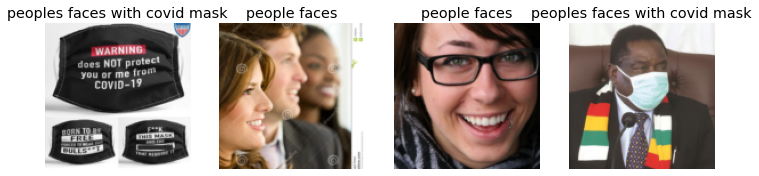

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

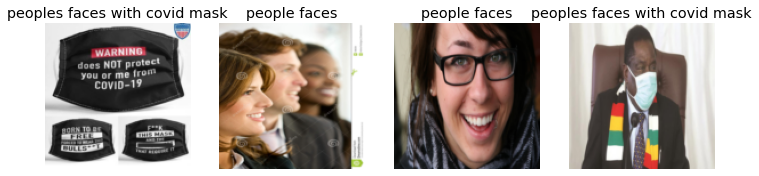

In [ ]:
masks = masks.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = masks.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

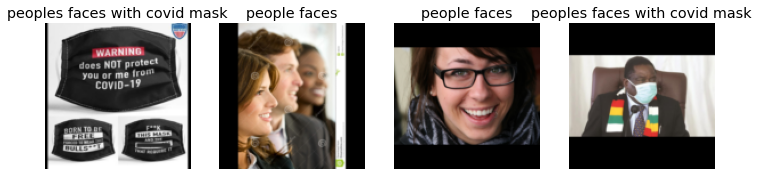

In [ ]:
masks =masks.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = masks.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

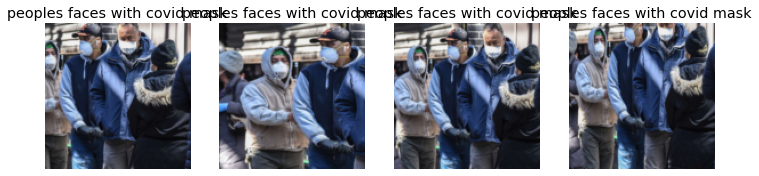

In [ ]:
masks = masks.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = masks.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [ ]:
masks = masks.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = masks.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


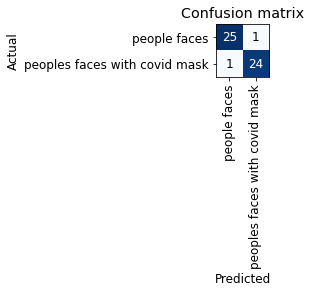

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

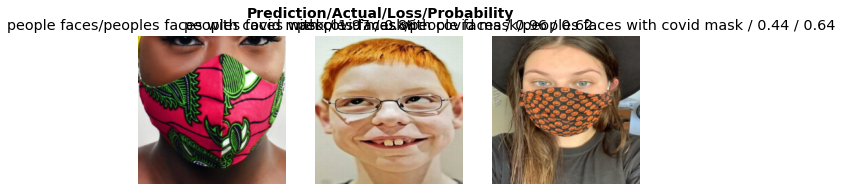

In [ ]:
interp.plot_top_losses(3, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]